In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

We are curious about the relationships between different leading indicators to the lagging indicator (Fare)

We can only use train data to investigate the relationships

### Exploratory Data Analysis

In [3]:
train = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv',nrows=1000000)
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train.shape

(1000000, 8)

#### Data Cleaning

1. data not make sense

2. null values

3. outliers

In [5]:
#fare amount should be larger than 0 
train = train[(train['fare_amount'] >= 0)&(train['fare_amount'] <= 200)]

In [6]:
#There should not be missing values
#Here we can see there is not any missing value
train.dropna(inplace=True)
train.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [7]:
#outliers
#First get descriptive stats
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999914.000000,999914.000000,999914.000000,999914.000000,999914.000000,999914.000000
mean,11.338718,-72.527039,39.929222,-72.528423,39.920254,1.684949
std,9.673256,12.056922,7.625747,11.322829,8.200851,1.323922
min,0.000000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734966,-73.991385,40.734047,1.000000
50%,8.500000,-73.981793,40.752695,-73.980136,40.753165,1.000000
75%,12.500000,-73.967097,40.767153,-73.963655,40.768127,2.000000
max,200.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


From here we can see pick_up_longitude and pickup_latitude actually have a small IQR. It is likely there are some wrong or outliers here. Let us visualize

In [8]:
train = train[(train['pickup_longitude'] < -72)&(train['pickup_longitude'] > -75)]
train = train[(train['pickup_latitude'] < 44)&(train['pickup_latitude'] > 37)]
train = train[(train['dropoff_longitude'] < -72)&(train['dropoff_longitude'] > -75)]
train = train[(train['dropoff_latitude'] > 37) & (train['dropoff_latitude'] < 44)]
train = train[(train['passenger_count'] < 10)&(train['passenger_count'] > 0)]

In [9]:
def finding_distance(df):
    R = 6373.0
    lat1 =np.asarray(np.radians(df['pickup_latitude']))
    lon1 = np.asarray(np.radians(df['pickup_longitude']))
    lat2 = np.asarray(np.radians(df['dropoff_latitude']))
    lon2 = np.asarray(np.radians(df['dropoff_longitude']))

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    ls1=[] 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/ 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    
    df['Distance']=np.asarray(distance)*0.621

finding_distance(train)
train = train[train['Distance'] < 50]

<AxesSubplot:xlabel='dropoff_longitude', ylabel='Count'>

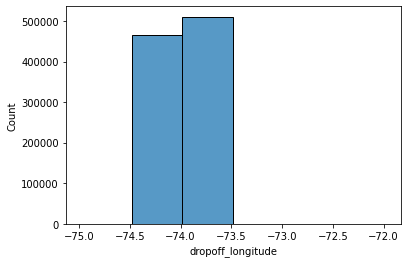

In [10]:
#Distributution of drop off Longitude
sns.histplot(train['dropoff_longitude'],binwidth = 0.5)

<AxesSubplot:xlabel='dropoff_latitude', ylabel='Count'>

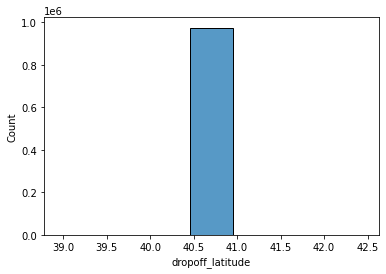

In [11]:
#Distributution of drop off Latitude
sns.histplot(train['dropoff_latitude'],binwidth = 0.5)

<AxesSubplot:xlabel='pickup_longitude', ylabel='Count'>

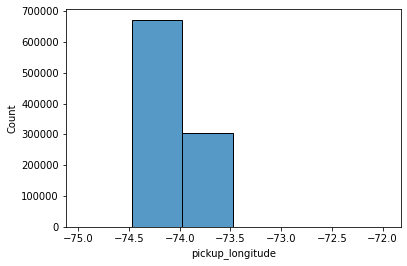

In [12]:
#Distributution of Longitude
sns.histplot(train['pickup_longitude'],binwidth = 0.5)

<AxesSubplot:xlabel='pickup_latitude', ylabel='Count'>

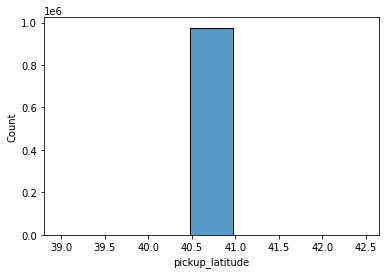

In [13]:
#Distributution of Latitude
sns.histplot(train['pickup_latitude'],binwidth = 0.5)


Get rid of the right part (These are outliers)

In [14]:
round(train.describe(),2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
count,975579.00,975579.00,975579.00,975579.00,975579.00,975579.00,975579.00
mean,11.33,-73.98,40.75,-73.97,40.75,1.69,2.06
std,9.61,0.04,0.03,0.04,0.03,1.31,2.23
min,0.00,-74.97,38.98,-74.98,38.96,1.00,0.00
25%,6.00,-73.99,40.74,-73.99,40.74,1.00,0.78
50%,8.50,-73.98,40.75,-73.98,40.75,1.00,1.34
75%,12.50,-73.97,40.77,-73.97,40.77,2.00,2.43
max,200.00,-72.19,42.16,-72.15,42.17,6.00,48.30


**From the decription statistics above**, everything looks clean now

#### Visualization of EDA


#### Timing and Fare

We think timing (different days in week, different months) may be a leading factor for different price

Firstly, get different parts of times as new columns

In [15]:
train["date_parsed"] = pd.to_datetime(train["pickup_datetime"])

train["Year"] = train["date_parsed"].dt.year

train["Month"] = train["date_parsed"].dt.month

train["Weekday"] = train["date_parsed"].dt.weekday

train["hour"] = train["date_parsed"].dt.hour

train = train.drop(columns = ["key","pickup_datetime", "date_parsed"])

**Note**, this would be the new data frame we use to research the relationship between timing and fare

In [16]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,Year,Month,Weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.640305,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5.249180,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.863166,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,1.738893,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.241866,2010,3,1,7


Text(0, 0.5, 'Fare distribution')

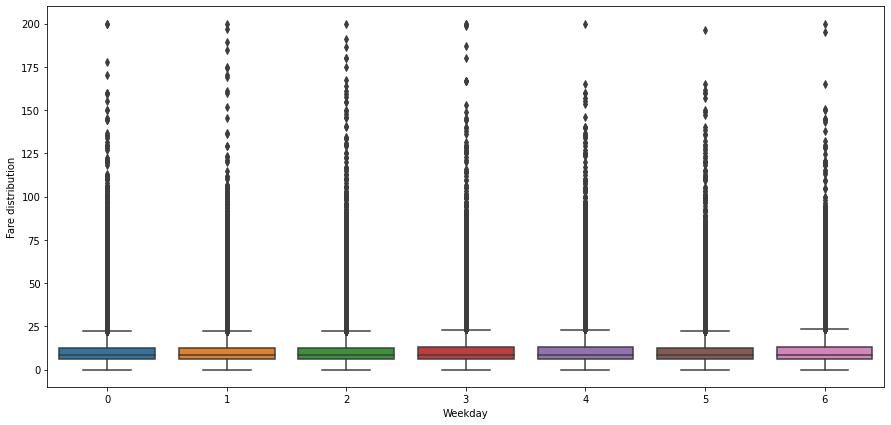

In [17]:
plt.figure(figsize=(15,7))
sns.boxplot(x = train["Weekday"], y = train["fare_amount"])
plt.xlabel('Weekday')
plt.ylabel('Fare distribution')

**Surprisingly**, from the plot, weekday seems not to influence the fare amount significantly

Text(0, 0.5, 'Fare distribution')

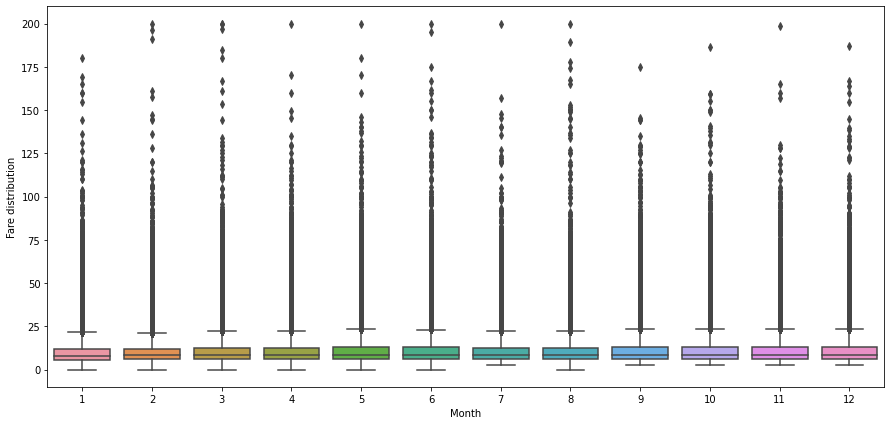

In [18]:
#Visualize the relationship between month and fare
plt.figure(figsize=(15,7))
sns.boxplot(x = train["Month"], y = train["fare_amount"])
plt.xlabel('Month')
plt.ylabel('Fare distribution')

The influence is also not significant!

Text(0, 0.5, 'Fare distribution')

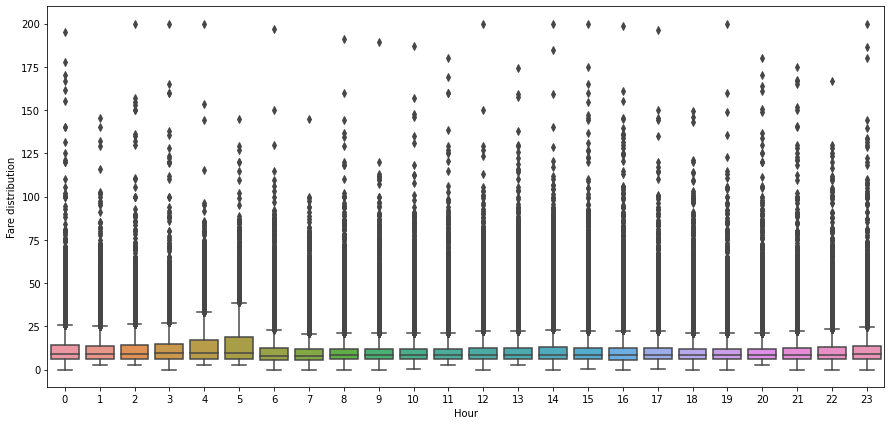

In [19]:
#Visualize the relationship between hour and fare
plt.figure(figsize=(15,7))
sns.boxplot(x = train["hour"], y = train["fare_amount"])
plt.xlabel('Hour')
plt.ylabel('Fare distribution')

This suggests some relationship. The boxplot suggests 4-5am have a relatively high overall fare amount. Why does this happen? we can see the frequency of the observations

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='hour', ylabel='count'>

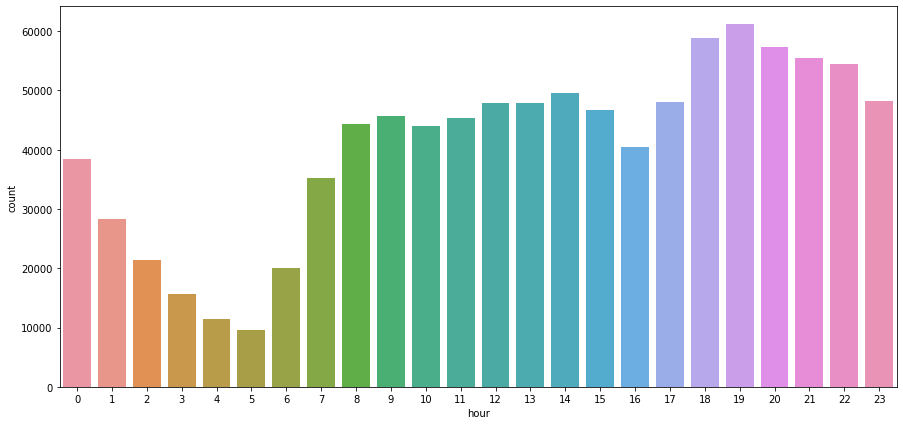

In [20]:
#Visualize the density of hour
plt.figure(figsize=(15,7))
sns.countplot(train["hour"])

In [21]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,Year,Month,Weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.640305,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5.249180,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.863166,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,1.738893,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.241866,2010,3,1,7


<AxesSubplot:xlabel='passenger_count', ylabel='Count'>

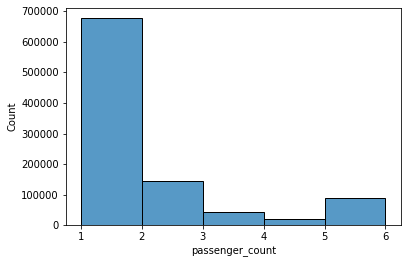

In [22]:
sns.histplot(train['passenger_count'],binwidth = 1)


<AxesSubplot:xlabel='Distance', ylabel='Count'>

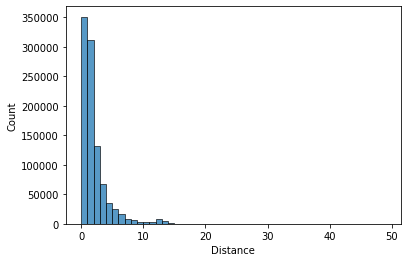

In [23]:
sns.histplot(train['Distance'],binwidth = 1)

Text(0, 0.5, 'Fare distribution')

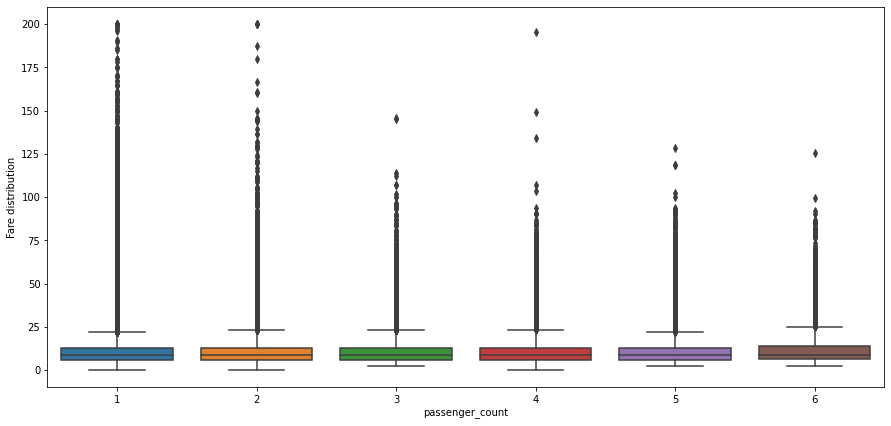

In [24]:
plt.figure(figsize=(15,7))
sns.boxplot(x = train["passenger_count"], y = train["fare_amount"])
plt.xlabel('passenger_count')
plt.ylabel('Fare distribution')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

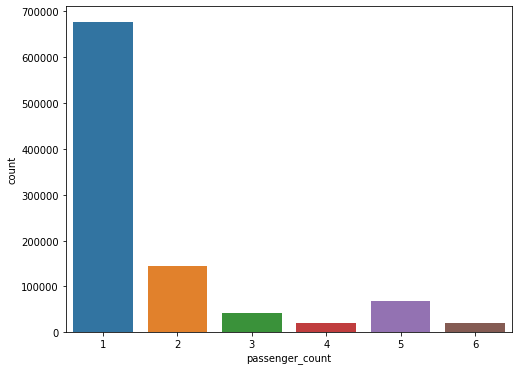

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(train["passenger_count"])

In [26]:
train_df=train


In [27]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,Year,Month,Weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.640305,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5.249180,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.863166,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,1.738893,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.241866,2010,3,1,7


In [28]:

from sklearn.linear_model import LinearRegression
# lr=LinearRegression(normalize=True)
lr=LinearRegression()
from sklearn.model_selection import train_test_split
X=train_df.drop(['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','Year','Month','Weekday'],axis=1)
y=train_df['fare_amount']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.01,random_state=80)
reg=lr.fit(X_train.values,y_train.values)
reg.intercept_

3.497221895654657

In [29]:
print(X.head())

   passenger_count  Distance  hour
0                1  0.640305    17
1                1  5.249180    16
2                2  0.863166     0
3                1  1.738893     4
4                1  1.241866     7


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_pred = reg.predict(X_test.values)
# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred,squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [0.02442728 3.70657377 0.01168176]
Mean squared error: 4.44
Coefficient of determination: 0.78


In [31]:
test = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')
train=test
train = train[(train['pickup_longitude'] < -72)&(train['pickup_longitude'] > -75)]
train = train[(train['pickup_latitude'] < 44)&(train['pickup_latitude'] > 37)]
train = train[(train['dropoff_longitude'] < -72)&(train['dropoff_longitude'] > -75)]
train = train[(train['dropoff_latitude'] > 37) & (train['dropoff_latitude'] < 44)]
train = train[(train['passenger_count'] < 10)&(train['passenger_count'] > 0)]
train["date_parsed"] = pd.to_datetime(train["pickup_datetime"])

train["Year"] = train["date_parsed"].dt.year

train["Month"] = train["date_parsed"].dt.month

train["Weekday"] = train["date_parsed"].dt.weekday

train["hour"] = train["date_parsed"].dt.hour

train = train.drop(columns = ["key","pickup_datetime", "date_parsed"])
finding_distance(train)
X=train.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','Year','Month','Weekday'],axis=1)
y_pred_test= reg.predict(X.values)

In [32]:
X['pre_fare']=y_pred_test
X

,passenger_count,hour,Distance,pre_fare
0,1,13,1.443197,51.723967
1,1,13,1.506617,51.724708
2,1,11,0.384289,44.298450
3,1,21,1.218183,81.373929
4,1,21,3.346564,81.398792
...,...,...,...,...
9909,6,12,1.319961,48.138090
9910,6,17,2.031909,66.679276
9911,6,20,11.916967,77.914472
9912,6,1,5.182932,7.410905


You cann see there are smallest number of taxis between 4-5 am. This might suggest an overall high fee during this period